In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [15]:
fake = pd.read_csv("/content/sample_data/Fake.csv")
true = pd.read_csv("/content/sample_data/True.csv")

In [16]:
fake.shape

(23481, 4)

In [17]:
true.shape

(21417, 4)

In [18]:
fake['target'] = 'fake'
true['target'] = 'true'

In [19]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [20]:
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [21]:
data.head()

,title,text,subject,date,target
0,"Subdued by Harvey, Congress reconvenes facing ...",WASHINGTON (Reuters) - Hurricane Harvey devast...,politicsNews,"September 4, 2017",true
1,Trump to give speech on illegal immigration on...,WASHINGTON (Reuters) - U.S. Republican preside...,politicsNews,"August 28, 2016",true
2,RUSH TO FINISH: OBAMA SLAPS $5 BILLION In Regu...,Clyde Wayne Crews of the Competitive Enterpris...,left-news,"Nov 21, 2016",fake
3,DRAMA QUEEN CHRIS MATTHEWS Claims Republican ‘...,MSNBC host Chris Matthews on Thursday accused ...,politics,"Oct 7, 2017",fake
4,RUSH LIMBAUGH Tells His Own Theory Of The Lync...,Rush Limbaugh weighed in on what he thinks hap...,politics,"Jul 1, 2016",fake


In [22]:
# Removing the date
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,"Subdued by Harvey, Congress reconvenes facing ...",WASHINGTON (Reuters) - Hurricane Harvey devast...,politicsNews,true
1,Trump to give speech on illegal immigration on...,WASHINGTON (Reuters) - U.S. Republican preside...,politicsNews,true
2,RUSH TO FINISH: OBAMA SLAPS $5 BILLION In Regu...,Clyde Wayne Crews of the Competitive Enterpris...,left-news,fake
3,DRAMA QUEEN CHRIS MATTHEWS Claims Republican ‘...,MSNBC host Chris Matthews on Thursday accused ...,politics,fake
4,RUSH LIMBAUGH Tells His Own Theory Of The Lync...,Rush Limbaugh weighed in on what he thinks hap...,politics,fake


In [23]:
# Removing the title
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,WASHINGTON (Reuters) - Hurricane Harvey devast...,politicsNews,true
1,WASHINGTON (Reuters) - U.S. Republican preside...,politicsNews,true
2,Clyde Wayne Crews of the Competitive Enterpris...,left-news,fake
3,MSNBC host Chris Matthews on Thursday accused ...,politics,fake
4,Rush Limbaugh weighed in on what he thinks hap...,politics,fake


In [24]:
# Convert to lowercase
data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,washington (reuters) - hurricane harvey devast...,politicsNews,true
1,washington (reuters) - u.s. republican preside...,politicsNews,true
2,clyde wayne crews of the competitive enterpris...,left-news,fake
3,msnbc host chris matthews on thursday accused ...,politics,fake
4,rush limbaugh weighed in on what he thinks hap...,politics,fake


In [25]:
# Remove punctuation
import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [26]:
data.head()

,text,subject,target
0,washington reuters hurricane harvey devastate...,politicsNews,true
1,washington reuters us republican presidential...,politicsNews,true
2,clyde wayne crews of the competitive enterpris...,left-news,fake
3,msnbc host chris matthews on thursday accused ...,politics,fake
4,rush limbaugh weighed in on what he thinks hap...,politics,fake


In [27]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


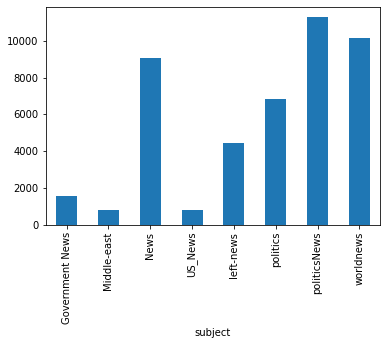

In [28]:
#articles per subject
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


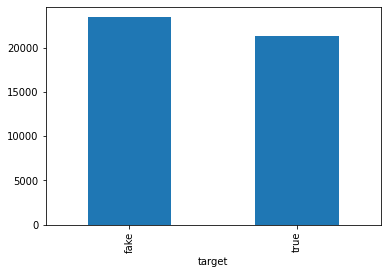

In [29]:
#fake and real articles
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

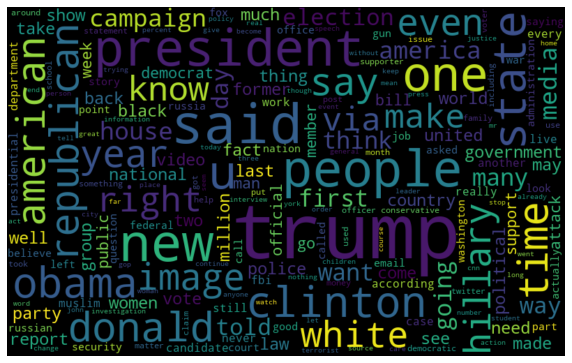

In [30]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

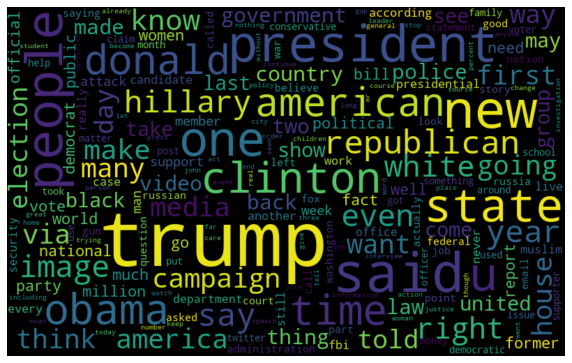

In [31]:
# Word cloud for True news
from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [32]:
# Most frequent words counter
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

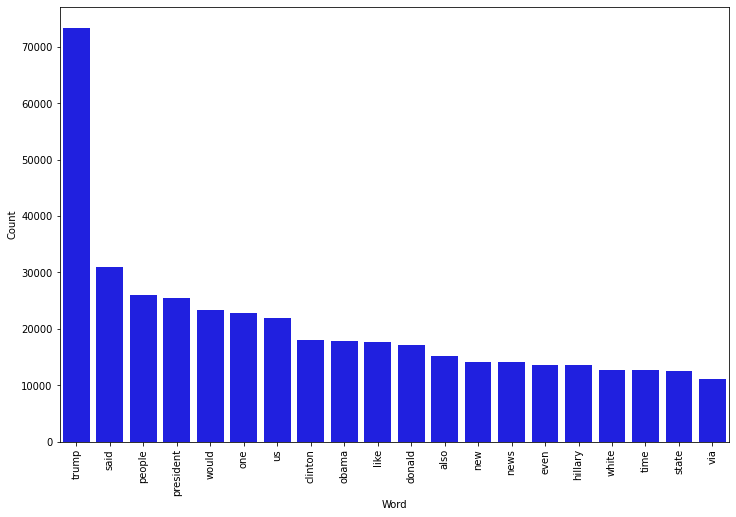

In [33]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

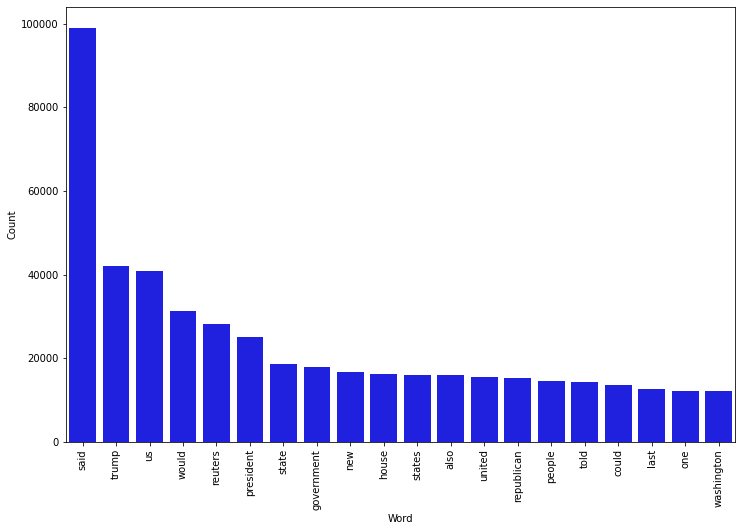

In [34]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

In [35]:
# Function to plot the confusion matrix
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [36]:
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

Logistic regression

In [37]:
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.04%


Confusion matrix, without normalization


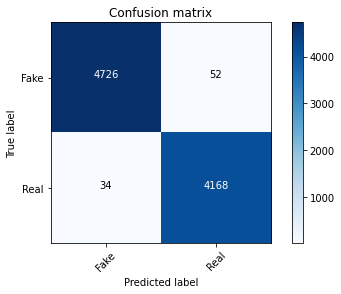

In [38]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

Random Forest Classifier

In [40]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 98.95%


Confusion matrix, without normalization


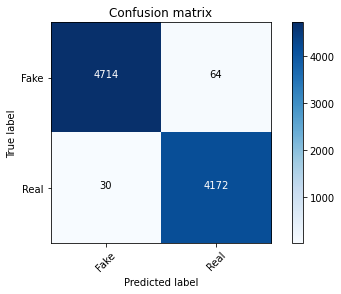

In [41]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])